In [1]:
import thirdparty
from thirdparty import *
from transformers import CLIPProcessor, CLIPModel

# 观察训练数据

In [2]:
# 统计COCO中图像数据的个数
data_dir = "/root/autodl-tmp/data/COCO/"
file_train = os.listdir(os.path.join(data_dir,"train_image"))
file_test = os.listdir(os.path.join(data_dir,"test_image"))
file_val = os.listdir(os.path.join(data_dir,"val_image"))
print(len(file_train))
print(len(file_test))
print(len(file_val))

118287
40670
5000


In [3]:
text_dir = "/root/autodl-tmp/data/image-text-match/"
with open(os.path.join(text_dir,"train_data"),encoding="utf-8") as f:
    train_lines=[eval(s.strip()) for s in f.readlines()]
print(train_lines[0])
print (len(train_lines))
with open(os.path.join(text_dir,"val_data"),encoding="utf-8") as f:
    val_lines=[eval(s.strip()) for s in f.readlines()]
print(val_lines[0])
print (len(val_lines))

['000000203564.jpg', '自行车复制品 时钟当前轮']
591753
['000000179765.jpg', '一辆黑色本田摩托车停在车库前']
25014


# 导入数据

In [4]:
def get_data(lines,path_dir,num=200):
    lines=[s for s in lines  if len(s[1])>0 and len(s[1])<20]
    images=[]
    texts=[]
    for p,text in lines:
        try:  
            path=str(path_dir)+p   
            images.append(path)        
            texts.append(text)
        except:
            continue
    return images,texts
train_images_dir,train_texts=get_data(train_lines,"/root/autodl-tmp/data/COCO/train_image/")
val_images_dir,val_texts=get_data(val_lines,"/root/autodl-tmp/data/COCO/val_image/")
print(len(train_images_dir))
print(len(val_images_dir))

504503
21363


(480, 640, 3)


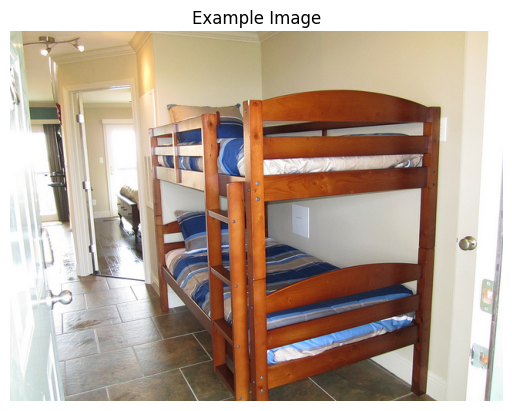

一套套在房子的床铺上


In [5]:
index=405000
image_path,text=train_images_dir[index],train_texts[index]
img = Image.open(image_path)
image=np.array(img)
print(image.shape)
image_show(image,"rgb")
print(text)

# 导入模型

In [6]:
device=get_device()
model_dir="/root/autodl-tmp/model/"#/root/autodl-tmp/model/
model = CLIPModel.from_pretrained(os.path.join(model_dir,"clip-vit-base")).to(device)

/root/miniconda3/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
#观察模型
print (model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [9]:
processor = CLIPProcessor.from_pretrained(os.path.join(model_dir,"clip-vit-base"))
#图像传入要是256像素的格式
print(processor)
#返回loss
model.return_loss=True
#冻结住图像的encoder，只训练文本部分text encoder
for name, param in model.vision_model.named_parameters():
        param.requires_grad=False

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='/root/autodl-tmp/model/clip-vit-base', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=T

In [10]:
print(processor.tokenizer)

CLIPTokenizerFast(name_or_path='/root/autodl-tmp/model/clip-vit-base', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


# 制作数据集

In [11]:
class ToIntTensor(object):
    def __call__(self, pic):
        tensor = transforms.functional.to_tensor(pic)
        tensor = (tensor * 255).to(torch.uint8)
        return tensor
show_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    ToIntTensor()
])
class ImageTextDataset(Dataset):
    def __init__(self, image_paths, captions,transform=None):
        self.image_paths = image_paths
        self.captions = captions
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        # 加载图像
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        # 加载文本
        caption = self.captions[idx]
        if self.transform:
            image = self.transform(image)
        return image, caption

In [12]:
batch_size = 256
train_dataset=ImageTextDataset(train_images_dir,train_texts,transform=show_tfm)
train_set = DataLoader(train_dataset, batch_size=batch_size,shuffle = True)
val_dataset=ImageTextDataset(val_images_dir,val_texts,transform=show_tfm)
val_set = DataLoader(val_dataset, batch_size=batch_size,shuffle = False,drop_last=False)

# 观察模型输出

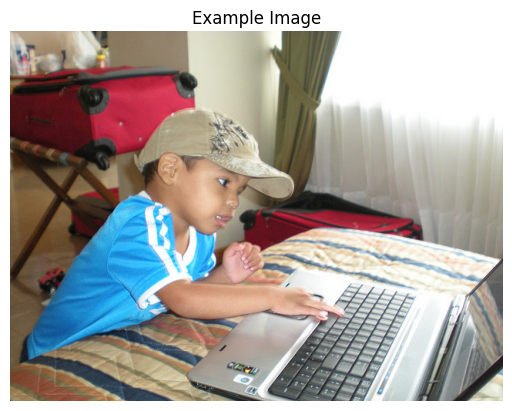

torch.Size([1, 512])
torch.Size([1, 512])


In [13]:
#从clip模型中获取文本模块
text_model=model.text_model
#从clip模型中，获取图像模块
vision_model=model.vision_model
path = "/root/autodl-tmp/data/COCO/val_image/000000358525.jpg"#000000179765.jpg
image = Image.open(path)
image = np.array(image)
image_show(image,"rgb")
text_inputs = processor(text="一辆黑色本田摩托车 背着黑色的布贡迪座椅", return_tensors="pt", padding=True).to("cuda:0")
img_inputs = processor(images=image, return_tensors="pt").to("cuda:0")
#获取文本向量，last_hidden_state 输出最后一层对应的向量
#第一个：对应的所有batchsize 第二个：对应的是整个向量
text_output=text_model(**text_inputs).last_hidden_state[:, 0, :]
#Vit的输出也是个向量序列
image_output=vision_model(**img_inputs).last_hidden_state[:, 0, :]
text_output=model.text_projection(text_output)
image_output=model.visual_projection(image_output)
print (text_output.shape)
print (image_output.shape)

# 测试原始模型

tensor([[21.0981, 17.5464]], device='cuda:0', grad_fn=<TBackward0>)
tensor([[0.9721, 0.0279]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


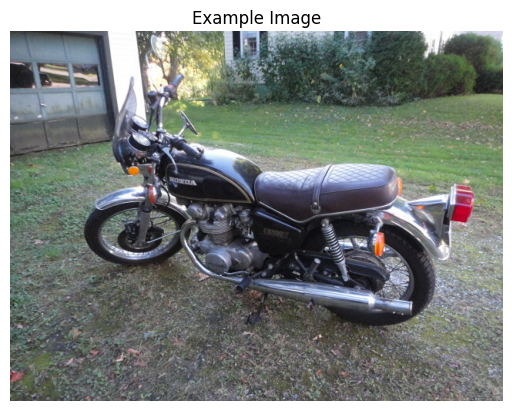

In [14]:
path = "/root/autodl-tmp/data/COCO/val_image/000000179765.jpg"#000000179765
image = Image.open(path)
inputs = processor(text=["一辆黑色本田摩托车 背着黑色的布贡迪座椅","一张有喷泉的厕所的特写照片"], images=image, return_tensors="pt", padding=True).to(device)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
print (logits_per_image)
print (probs)
image_show(np.array(image),"rgb")

# 训练

In [15]:
config = {
    'n_epochs': 2,                # maximum number of epochs
    'optimizer': 'Adam',             # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0003,                 # learning rate of Adam
        'betas' : (0.9,0.999),           #hyperparameter for momentum and gradient
        'eps':1e-5,                  # parameter for zero division
        'weight_decay': 1e-8        # weight decay (L2 regularization)  
    },
    'batch_show_step':5,
    'epoch_show_step':1,
    'save_dir':'./finetune-model/clip/'
}
myseed = 42069  # set a random seed for reproducibility
set_seed(myseed)

In [16]:
def train(train_set, model, config, device):
    ''' Model training '''
    n_epochs = config['n_epochs']  # Maximum number of epochs
    batch_show_step,epoch_show_step=config["batch_show_step"],config["epoch_show_step"]
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
    min_loss = 10000.
    epoch = 0
    while epoch < n_epochs:
        model.train()
        step = 0
        show_flag=False
        if((epoch + 1) % epoch_show_step == 1 or epoch_show_step == 1): show_flag=True
        for images, texts in train_set:  # iterate through the dataloader
            # 前向传播计算loss
            optimizer.zero_grad() # 梯度置零，因为反向传播过程中梯度会累加上一次循环的梯度
            inputs = processor(text=texts, images=images,return_tensors="pt", padding=True ).to(device)      
            loss= model(**inputs,return_loss=True,return_dict=False)[0]
            loss.backward() # loss反向传播
            optimizer.step() # 反向传播后参数更新
            step += 1
            if(show_flag):
                if (step % batch_show_step == 1 or batch_show_step==1):
                    print('epoch{:4d}|step = {:4d}, train_loss = {:.4f}'.format(epoch + 1, step,loss))
            if(step%100==0):
                model.save_pretrained(config['save_dir'])
                torch.save(model, os.path.join(config['save_dir'],"pytorch_model.bin"))

In [17]:
train(train_set, model, config, device)

epoch   1|step =    1, train_loss = 5.9485
epoch   1|step =    6, train_loss = 5.9788
epoch   1|step =   11, train_loss = 5.8967
epoch   1|step =   16, train_loss = 5.6634
epoch   1|step =   21, train_loss = 5.6377
epoch   1|step =   26, train_loss = 5.5940
epoch   1|step =   31, train_loss = 5.5020
epoch   1|step =   36, train_loss = 5.3677
epoch   1|step =   41, train_loss = 5.3346
epoch   1|step =   46, train_loss = 5.3101
epoch   1|step =   51, train_loss = 5.1820
epoch   1|step =   56, train_loss = 5.1680
epoch   1|step =   61, train_loss = 5.0916
epoch   1|step =   66, train_loss = 4.9240
epoch   1|step =   71, train_loss = 4.8783
epoch   1|step =   76, train_loss = 4.6276
epoch   1|step =   81, train_loss = 4.5183
epoch   1|step =   86, train_loss = 4.3284
epoch   1|step =   91, train_loss = 4.2032
epoch   1|step =   96, train_loss = 4.1015
epoch   1|step =  101, train_loss = 3.6982
epoch   1|step =  106, train_loss = 3.6125
epoch   1|step =  111, train_loss = 3.6504
epoch   1|s

KeyboardInterrupt: 

# 测试

In [18]:
def val(val_set, model, config, device):
    result = []
    batch = 0
    for images, texts in val_set:
        texts_shuffle = list(texts)
        random.shuffle(texts_shuffle)    
        texts_test = []
        for i in range(len(texts)):
            texts_test.append([texts[i],texts_shuffle[i]])
        for k in range(len(texts_test)):
            # print(texts_test[k])
            # image_show(images[k].numpy(),"rgb")
            inputs = processor(text=texts_test[k], images=images[k], return_tensors="pt", padding=True).to(device)
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # 获取图像-文本相似度得分
            probs = logits_per_image.softmax(dim=1)  # 获取标签概率
            # 处理每个批次中的每个实例
            for prob in probs:
                score1, score2 = prob.tolist()  # 提取当前实例的概率分数
                score = score1 - score2  # 计算正样本与负样本的分数差异
                result.append(score)  # 将结果添加到result列表中
        batch+=1
        print("finish batch {:5d}, finish number {:5d}, current socre {:.5f}".format(batch,batch*batch_size,sum(result)/len(result)))
    return sum(result)/len(result)

In [19]:
model_dir = "/root/autodl-tmp/model/"
model_name="./finetune-model/clip"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(os.path.join(model_dir,"clip-vit-base"))
score = val(val_set, model, config, device)
print(score)

finish batch     1, finish number   256, current socre 0.93252
finish batch     2, finish number   512, current socre 0.93714
finish batch     3, finish number   768, current socre 0.94776
finish batch     4, finish number  1024, current socre 0.93707
finish batch     5, finish number  1280, current socre 0.93886
finish batch     6, finish number  1536, current socre 0.93833
finish batch     7, finish number  1792, current socre 0.93971
finish batch     8, finish number  2048, current socre 0.93781
finish batch     9, finish number  2304, current socre 0.93712
finish batch    10, finish number  2560, current socre 0.94133
finish batch    11, finish number  2816, current socre 0.94176
finish batch    12, finish number  3072, current socre 0.93843
finish batch    13, finish number  3328, current socre 0.93755
finish batch    14, finish number  3584, current socre 0.93829
finish batch    15, finish number  3840, current socre 0.93994
finish batch    16, finish number  4096, current socre 

In [20]:
model_dir = "/root/autodl-tmp/model/"
model = CLIPModel.from_pretrained(os.path.join(model_dir,"clip-vit-base")).to(device)
processor = CLIPProcessor.from_pretrained(os.path.join(model_dir,"clip-vit-base"))
score = val(val_set, model, config, device)
print(score)

finish batch     1, finish number   256, current socre 0.28997
finish batch     2, finish number   512, current socre 0.28694
finish batch     3, finish number   768, current socre 0.29056
finish batch     4, finish number  1024, current socre 0.27748
finish batch     5, finish number  1280, current socre 0.27001
finish batch     6, finish number  1536, current socre 0.27482
finish batch     7, finish number  1792, current socre 0.26619
finish batch     8, finish number  2048, current socre 0.27039
finish batch     9, finish number  2304, current socre 0.26654
finish batch    10, finish number  2560, current socre 0.26545
finish batch    11, finish number  2816, current socre 0.26400
finish batch    12, finish number  3072, current socre 0.26618
finish batch    13, finish number  3328, current socre 0.26384
finish batch    14, finish number  3584, current socre 0.26729
finish batch    15, finish number  3840, current socre 0.26676
finish batch    16, finish number  4096, current socre 